In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine('sqlite:///hawaii.sqlite')

In [6]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [9]:
Measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [10]:
Station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [11]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

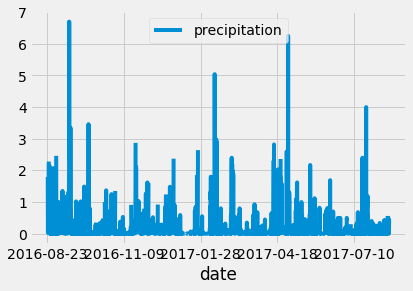

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 
prev_year=dt.date(2017,8,23)
# Calculate the date one year from the last date in data set.
prev_year=dt.date(2017,8,23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
results=[]
results=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=prev_year).all()
# print(results)
# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(results,columns=['date','precipitation'])
df.set_index(df['date'], inplace=True)
# print(df.to_string(index=False))
# Sort the dataframe by date
df=df.sort_index()
# print(df.to_string(index=False))
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()

In [13]:
print(prev_year)

2016-08-23


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [16]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

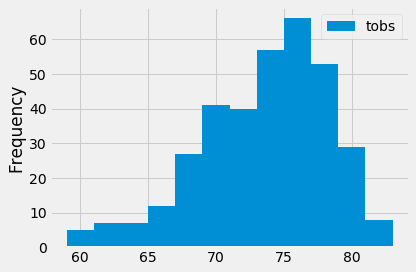

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results=session.query(Measurement.tobs).\
    filter(Measurement.station=='USC00519281').\
          filter(Measurement.date>=prev_year).all()
df=pd.DataFrame(results,columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()

In [19]:
# Write a function called `calc_temps` that will accept start date and end date in the format
#'%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start, end):
    #Define dates as '%Y-%m-%d'
    try:
        start_date=datetime.strptime(start,'%Y-%m-%d')
    except:
        start_date=input('Start date invalid format, please re-enter as YYYY-MM-DD')
        try:
            start_date=datetime.strptime(start,'%Y-%m-%d')
        except:
            start_date=date.today()
            start_date=datetime.strptime(start,'%Y-%m-%d')
            print('Start date defined as :', start_date)
        
    try:
        end_date=datetime.strptime(end,'%Y-%m-%d')
    except:
        end_date=input('End date invalid format, please re-enter as YYYY-MM-DD')
        try:
            end_date=datetime.strptime(end,'%Y-%m-%d')
        except:
            end_date=start_date - dt.timedelta(days=365)
            end_date=datetime.strptime(end,'%Y-%m-%d')
            print('End date defined as :', end_date)
    
    #Get Min, Max and AVG temperatures between start and end date
    result=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station=='USC00519281'). \
                   filter(Measurement.date>=end_date). \
                   filter(Measurement.date<=start_date).all()
    print(result)

In [20]:
calc_temps('2017-08-23', '2016-08-23')

[(59.0, 83.0, 73.0968660968661)]


# Challenge

Analyse Oahu island seasonal weather data with focus on summer (June) and winter (December) months.

The first attempt will be to look at the overall temperature and precipitation data and discuss the results.

If the results are not enough, a more deep analysis will be conducted.

## Temperature Analysis

In [59]:
#June temperature analysis - min, max and avg
june_data_temp=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(func.strftime('%m',Measurement.date)=='06').all()
june_data_temp

[(64.0, 85.0, 74.94411764705882)]

In [60]:
#December temperature analysis - min, max and avg
dec_data_temp=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(func.strftime('%m',Measurement.date)=='12').all()
dec_data_temp

[(56.0, 83.0, 71.04152933421226)]

The max and avg numbers for June and December data is close.

This analysis is not conclusive, further analysis for the entire month is necessary

## Precipitation Data

In [61]:
#June precipitation analysis - min, max and avg
june_data_prcp=session.query(func.min(Measurement.prcp), func.max(Measurement.prcp), func.avg(Measurement.prcp)).\
             filter(func.strftime('%m',Measurement.date)=='06').all()
june_data_prcp

[(0.0, 4.43, 0.13635959339263018)]

In [62]:
#December precipitation analysis - min, max and avg
dec_data_prcp=session.query(func.min(Measurement.prcp), func.max(Measurement.prcp), func.avg(Measurement.prcp)).\
             filter(func.strftime('%m',Measurement.date)=='12').all()
dec_data_prcp

[(0.0, 6.42, 0.21681850533807792)]

The precipitation data shows that December it's expected to have more rain in December.

This analysis is not conclusive, further analysis for the entire month is necessary

## In depth analysis

## June Analysis

In [40]:
#Get dataframe with June temperatures and precipitation data
june_data=session.query(Measurement.date, Measurement.station,\
                        Measurement.tobs, Measurement.prcp).\
             filter(func.strftime('%m',Measurement.date)=='06').all()
june_data_df=pd.DataFrame(june_data)
june_data_df.sort_values('date', axis=0)
june_data_df.head()

,date,station,tobs,prcp
0,2010-06-01,USC00519397,78.0,0.00
1,2010-06-02,USC00519397,76.0,0.01
2,2010-06-03,USC00519397,78.0,0.00
3,2010-06-04,USC00519397,76.0,0.00
4,2010-06-05,USC00519397,77.0,0.00


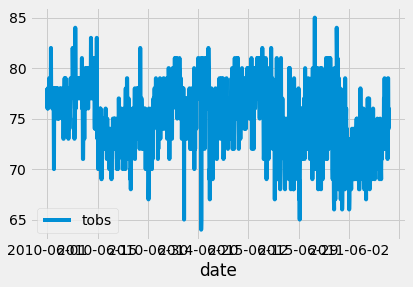

In [50]:
#Plot - June - temperature
june_data_df.plot('date', 'tobs')

In [55]:
#Statistical analysis - June - temperature
june_data_df['tobs'].describe()

count    1700.000000
mean       74.944118
std         3.257417
min        64.000000
25%        73.000000
50%        75.000000
75%        77.000000
max        85.000000
Name: tobs, dtype: float64

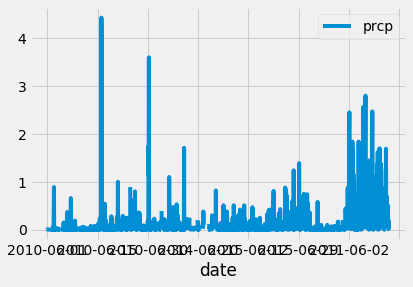

In [51]:
#Plot - June - precipitation
june_data_df.plot('date', 'prcp')

In [63]:
#Statistical analysis - June - precipitation
june_data_df['prcp'].describe()

count    1574.000000
mean        0.136360
std         0.335731
min         0.000000
25%         0.000000
50%         0.020000
75%         0.120000
max         4.430000
Name: prcp, dtype: float64

## December Analysis

In [64]:
#Get dataframe with December temperatures and precipitation data
dec_data=session.query(Measurement.date, Measurement.station,\
                        Measurement.tobs, Measurement.prcp).\
             filter(func.strftime('%m',Measurement.date)=='12').all()
dec_data_df=pd.DataFrame(dec_data)
dec_data_df.sort_values('date', axis=0)
dec_data_df.head()

,date,station,tobs,prcp
0,2010-12-01,USC00519397,76.0,0.04
1,2010-12-03,USC00519397,74.0,0.00
2,2010-12-04,USC00519397,74.0,0.00
3,2010-12-06,USC00519397,64.0,0.00
4,2010-12-07,USC00519397,64.0,0.00


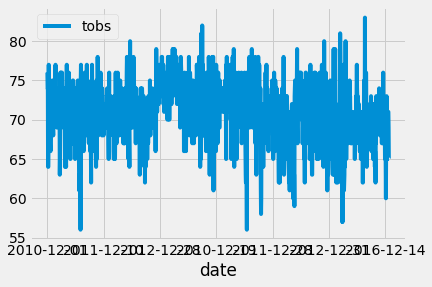

In [65]:
#Plot - December - temperature
dec_data_df.plot('date', 'tobs')

In [66]:
#Statistical analysis - December - temperature
dec_data_df['tobs'].describe()

count    1517.000000
mean       71.041529
std         3.745920
min        56.000000
25%        69.000000
50%        71.000000
75%        74.000000
max        83.000000
Name: tobs, dtype: float64

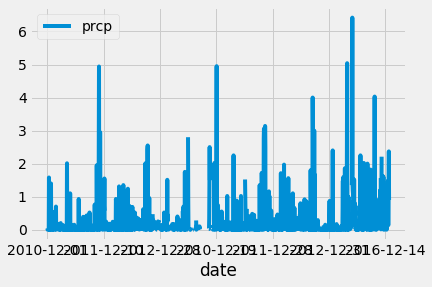

In [68]:
#Plot - December - precipitation
dec_data_df.plot('date', 'prcp')

In [69]:
#Statistical analysis - December - precipitation
dec_data_df['prcp'].describe()

count    1405.000000
mean        0.216819
std         0.541399
min         0.000000
25%         0.000000
50%         0.030000
75%         0.150000
max         6.420000
Name: prcp, dtype: float64

## Conclusion
The ***June analysis*** shows that during the month the temperature have several swings, however the min temperature (64-65°F) occur only three times over the month.

It's possible to notice that the temperature swings and the drops that happens by the end of the month are correlated to rainy days. The precipitation data shows 2 to 3 extreme rainy days during the month.

The ***December analysis*** shows that the temperatures are quite stable with variation between 65 to 75°F and the minimum temperature happens only few times.

The temperature and precipitation have the same correlation, what brings the temperatues down when it rains. There are more rain happening in December, with more extreame rainy days.

**Conclusion**

The temperatures and precipitation do not vary during the year. The winter is expected to have more rain which consequentely drops the temperature.

However, this drop is not significantly and probably do not avoid someone or go to surg or having an ice cream.

Rain do not necessarily means less surfers. Many surfers will look for rain days as the next day will bring stronger waves.

The temperatures are less concerning as most surfers have suits or special shirts that avoid the cold of the sea.

## Further Analysis

The temperature and precipitation analysis because there is not such drastic variation seems to be missing some points.

There two further analysis that can be done that could close the loop:
- Tourist information: understand the number of tourists per day or per month will be exential. As an island, relying only on the locals for business can have hard concequences on the long-term.

- Demographic distribution: the Oahu island is not big and the main city Honolulu can draw a lot competition. Undestanding the demographic distribution as well as the tourist information will allow to look for the best place to open business.